In [1]:
# packages
import numpy as np 
import yaml, os, logging, sys
import pandas as pd
pd.set_option("display.max_columns", None)
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from scipy import optimize
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, '/fefs/aswg/workspace/juan.jimenez/stereo_analysis/scripts')
import auxiliar as aux
import geometry as geom
aux.params()

import itertools
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SkyCoord
from astropy.time import Time
from regions import CircleSkyRegion, PointSkyRegion
from datetime import datetime, timedelta


# --- all gammapy sub-packages --- #
import gammapy
print(f"gammapy: v{gammapy.__version__}")
from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.makers import ReflectedRegionsBackgroundMaker, SafeMaskMaker, SpectrumDatasetMaker, WobbleRegionsFinder

from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import ExpCutoffPowerLawSpectralModel, LogParabolaSpectralModel, PowerLawSpectralModel
from gammapy.modeling.models import SkyModel, create_crab_spectral_model
from gammapy.visualization import plot_spectrum_datasets_off_regions
from gammapy.estimators import FluxPoints

import naima
from naima.models import ExponentialCutoffBrokenPowerLaw, InverseCompton, Synchrotron
# -------------------------------- #

plt.rcParams['lines.linewidth'] = 1.5

# creating a folder to save the plots
pltpath = '/fefs/aswg/workspace/juan.jimenez/stereo_analysis/thesis_plots/plots/'
dpi = 200     # resolution of saved images

gammapy: v1.0


## Selecting parameters
We will do the analysis with two different datasets:
- **MAGIC+LST performance paper dataset**
- **Data processed in this work**

In [2]:
# --- other parameters --- #
# name of the source we are studying
source_name = 'Crab Nebula'
# ------------------------ #

# --- data reduction parameters --- #
energy_min = '0.040 TeV'
energy_max = '25. TeV'
n_bins_pdec = 5

true_energy_min = '0.01 TeV'
true_energy_max = '100 TeV'
n_bins_pdec_true = 10

n_off_regions = 3
# --------------------------------- #

# --- SED function parameters --- #
sed_type = 'e2dnde'
yunits   = u.Unit('erg cm-2 s-1')

crab_model = create_crab_spectral_model('magic_lp')

# print(crab_model)
reference_models = {'Crab reference (MAGIC, JHEAp 2015)': crab_model,}
# ------------------------------- #


# --- file paths --- #
# dl3 files
input_dir = '/fefs/aswg/workspace/juan.jimenez/data/dl3_Crab/'
fermi_lat_sed_file = '/fefs/aswg/workspace/juan.jimenez/data/other_results/SED_Crab_FermiLAT_Arakawa2020.fits'
# ------------------ #


# some colors
colors = ['darkblue', 'darkorange', 'deeppink', 'darkviolet', 'crimson']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

### Reading and opening the provided `dl3` files

In [3]:
data_stored = DataStore.from_dir(input_dir)
    
print(f'\nOpening {len(data_stored.obs_table.to_pandas())} files-runs from {input_dir}.')
obs_ids = data_stored.obs_table.to_pandas()['OBS_ID'].to_numpy()
print(f'The runs analysed are:\n{obs_ids}')
display(data_stored.obs_table.to_pandas().head(4))


Opening 44 files-runs from /fefs/aswg/workspace/juan.jimenez/data/dl3_Crab/.
The runs analysed are:
[2923 3265 3266 3267 3268 3382 3383 3385 3631 3632 3633 3634 3635 3636
 3955 3956 4011 4012 4013 4014 4125 4126 7171 7198 7200 7201 7227 7228
 7229 7230 7231 7232 7233 7234 7235 7236 7237 7238 7255 7256 7277 7278
 7279 7282]


,OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
0,2923,b'2020-11-18',b'23:35:47.054',b'2020-11-18',b'23:52:39.650',83.965582,22.246383,45.061817,44.938183,86.404262,83.6333,22.0133,1.605743e+09,1.605744e+09,361.540171,1012.595825,327.730966,0.906486,b'Crab',b'WOBBLE',3,b'LST1_M1_M2',b'LST1_M1_M2'
1,3265,b'2020-12-15',b'21:27:18.722',b'2020-12-15',b'21:41:43.116',83.964766,22.247814,49.948381,40.051619,84.081655,83.6333,22.0133,1.608068e+09,1.608069e+09,377.947180,864.393870,359.643087,0.951570,b'Crab',b'WOBBLE',3,b'LST1_M1_M2',b'LST1_M1_M2'
2,3266,b'2020-12-15',b'21:43:24.497',b'2020-12-15',b'21:57:30.340',83.263007,21.787702,45.962274,44.037726,86.641861,83.6333,22.0133,1.608069e+09,1.608069e+09,381.712842,845.843447,363.603818,0.952559,b'Crab',b'WOBBLE',3,b'LST1_M1_M2',b'LST1_M1_M2'
3,3267,b'2020-12-15',b'21:59:19.731',b'2020-12-15',b'22:12:55.664',83.966751,22.246063,42.935176,47.064824,87.455726,83.6333,22.0133,1.608070e+09,1.608070e+09,363.771112,815.932556,346.981570,0.953846,b'Crab',b'WOBBLE',3,b'LST1_M1_M2',b'LST1_M1_M2'


### - Extracting Gammapy objects "Observation"
Containing a lot of information (e.g.: events, hdu tables, meta data,...).

### - Define the ON regions

Here we will collect the target position from observations metadata. To define the `on_region` we use `CircleSkyRegion` in case of global theta cuts, `PointSkyRegion` in case of dynamic theta cuts.

In [4]:
observation = data_stored.get_observations(None, required_irf='point-like')

# getting the metadata from the first run
first_observation = observation[0]
event_meta = first_observation.events.table.meta
aeff_meta  = first_observation.aeff.meta

# collecting the target position
target_position = SkyCoord(
    u.Quantity(event_meta['RA_OBJ'],  u.deg),
    u.Quantity(event_meta['DEC_OBJ'], u.deg),
    frame='icrs',
)

# global theta cuts
if 'RAD_MAX' in aeff_meta:
    # get the global theta cut used for creating the IRFs
    on_region_radius = aeff_meta['RAD_MAX'] * u.deg

    # use the circle sky region to apply the global theta cut
    on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
    print(f'\nPosition of the ON region (using global theta cuts): \n', on_region)

# dynamic theta cuts
else:
    # use the point sky region to apply dynamic theta cuts
    on_region = PointSkyRegion(target_position)
    print(f'\nPosition of the ON region (using dynamic theta cuts): \n', on_region)


Position of the ON region (using global theta cuts): 
 Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.6333, 22.0133)>
radius: 0.2 deg


### Running the data reduction chain

- Here we create the energy axes (reconstructed and true energy) and we set the number of OFF regions.
- We also create the Gammapy **Makers** needed to process the data.

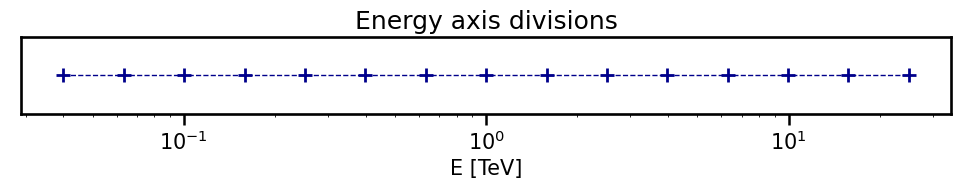


Creating geometry...
Number of OFF regions: 3


In [5]:
# ------- energy axis ------- #

# getting the energy axis
energy_axis = MapAxis.from_energy_bounds(
    energy_min,
    energy_max,
    nbin=n_bins_pdec,
    per_decade=True,
    name='energy',
)

# getting true energy axis (MC data)
energy_axis_true = MapAxis.from_energy_bounds(
    true_energy_min,
    true_energy_max,
    nbin=n_bins_pdec_true,
    per_decade=True,
    name='energy_true',
)

fig, ax = plt.subplots(figsize=(12,1))
ax.plot(energy_axis.edges, np.zeros(len(energy_axis.edges)), '+--', lw=1, ms=10)
ax.set_xscale('log')
ax.set_title('Energy axis divisions')
ax.set_yticks([])
ax.set_xlabel('E [TeV]')
plt.show()

# ------ creating the makers ------ #

# iterate over datasets
print(f'\nCreating geometry...')

# create ON region geometry
on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

# create a spectrum dataset maker
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=['counts', 'exposure', 'edisp'],
    use_region_center=True,
)

# create a background maker
print(f'Number of OFF regions: {n_off_regions}')

# finding the OFF regions
region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker     = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# create a safe mask maker
safe_mask_maker = SafeMaskMaker(methods=['aeff-max'], aeff_percent=10)

### Applying the makers

Now we apply the makers to the observations to create new datasets that contain the number of events, number of excess and background events, exposure and $\delta = 1/R_{OFF}$, where $R_{OFF}$ is the number of OFF regions. We will use this $\delta$ later to compute the Li & Ma significance.


In [6]:
datasets = Datasets()                                  
counts   = Map.create(skydir=target_position, width=3)

# Loop over every observation
print('Running the makers...')

n_observations = len(observation)

for i_obs, obs in enumerate(observation):

    if (i_obs % 10) == 0:
        print(f'{i_obs}/{n_observations}')

    obs_id = obs.obs_id

    # Fill the number of events in the map
    counts.fill_events(obs.events)

    # Run the makers to the observation data
    dataset        = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), obs)
    dataset_on_off = bkg_maker.run(dataset, obs)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, obs)

    datasets.append(dataset_on_off)

print(f'{n_observations}/{n_observations}')

# Get the information table
info_table = datasets.info_table(cumulative=True)

# Show the table
display(info_table.to_pandas().head(5))


Running the makers...
0/44
10/44
20/44
30/44
40/44
44/44


,name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
0,stacked,302,246.666656,18.003993,55.333336,117.000003,117.000003,NaN,620.592224,2.802178e+08,917.903553,1012.595825,0.329011,0.060282,0.268728,14,11,wstat,345.145979,166,11.0,33.0,0.333333
1,stacked,477,398.000000,23.480555,79.000000,178.500004,178.500004,NaN,620.592224,6.074629e+08,1740.434574,1876.989694,0.274069,0.045391,0.228679,14,11,wstat,580.472650,237,11.0,33.0,0.333333
2,stacked,700,591.000000,29.049109,109.000000,256.750010,256.750010,NaN,620.592224,8.679871e+08,2546.149953,2722.833142,0.274925,0.042810,0.232115,14,11,wstat,881.144314,327,11.0,33.0,0.333333
3,stacked,987,815.666626,33.212620,171.333344,375.250021,375.250021,NaN,2193.022705,1.087909e+09,3324.423847,3538.765698,0.296894,0.051538,0.245356,14,11,wstat,1161.577983,514,11.0,33.0,0.333333
4,stacked,1250,1018.000000,36.446940,232.000000,486.500033,486.500033,NaN,5171.354492,1.266862e+09,4064.416926,4314.685253,0.307547,0.057081,0.250466,14,11,wstat,1405.355191,696,11.0,33.0,0.333333


### Sky map

Let's create a counts map showing also the ON-OFF regions.
In the legend we list the run number for each set of OFF regions.

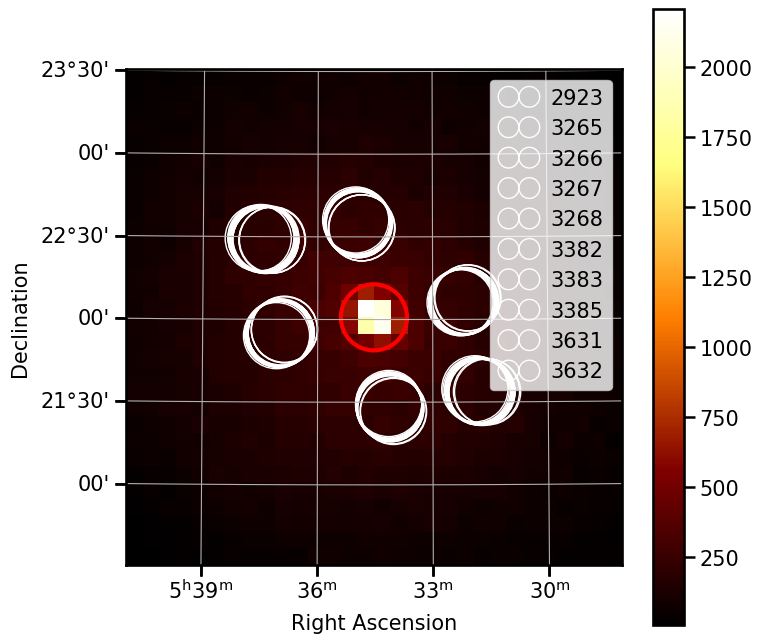

In [7]:
fig = plt.figure(figsize=(8,8))

# Plot the count map
ax = counts.plot(add_cbar=True)

# Plot the ON position
on_geom.plot_region(ax=ax, edgecolor='r', lw=3)

# Plot the OFF positions (only the first part of observations)
plot_spectrum_datasets_off_regions(datasets[:10], ax, edgecolor='w', legend=True, 
                                  prop_cycle=plt.cycler(color=list('w'*100)))
plot_spectrum_datasets_off_regions(datasets[10:], ax, edgecolor='w', legend=False, 
                                  prop_cycle=plt.cycler(color=list('w'*100)))
ax.grid()
plt.tick_params(axis='x', which='both', bottom=True, top=False)
plt.tick_params(axis='y', which='both', left=True, right=False)
plt.show()

### Excess significance

Now let's plot the number of events and significance (i.e. sqrt(TS), in $\sigma$ units) as a function of livetime, which is the total amount of usefull time collecting data from the target, i.e. livetime $= t_{on} - t_{dead}$.

As expected, the number of excess events (and so the significance) increase faster than the background in terms of the livetime, reaching a 50 $\sigma$ significance in less than 2 hours.

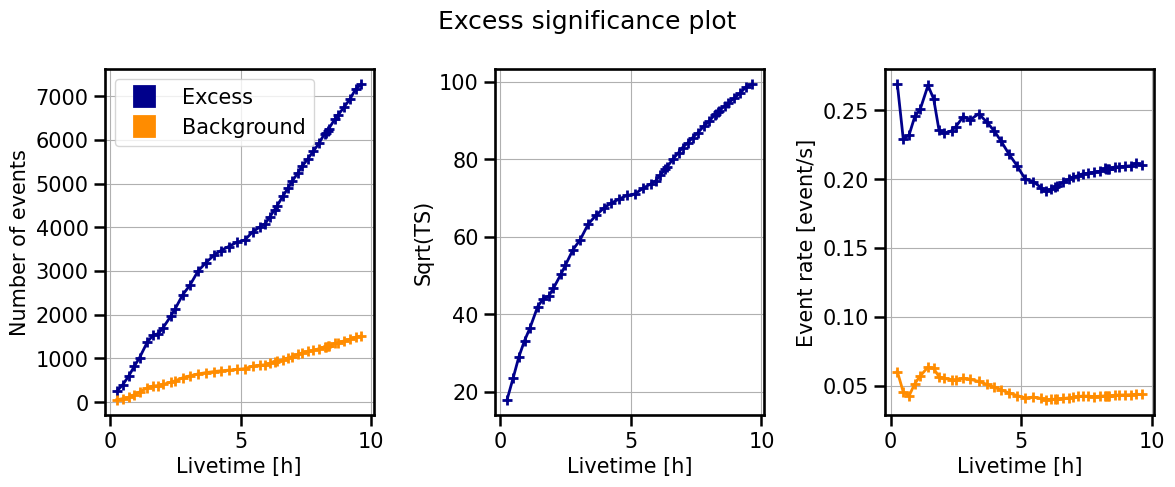

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

# plot the number of events along the livetime
ax1.plot(info_table['livetime'].to('h'), info_table['excess'],     marker='+', ls='-', lw=2, c='darkblue', ms=7)
ax1.plot(info_table['livetime'].to('h'), info_table['background'], marker='+', ls='-', lw=2, c='darkorange', ms=7)

# Plot the significance along the livetime
ax2.plot(info_table['livetime'].to('h'), info_table['sqrt_ts'], marker='+', ls='-', lw=2, c='darkblue', ms=7)

# plot the number of events along the livetime
ax3.plot(info_table['livetime'].to('h'), info_table['excess_rate'],     marker='+', ls='-', lw=2, c='darkblue', ms=7)
ax3.plot(info_table['livetime'].to('h'), info_table['background_rate'], marker='+', ls='-', lw=2, c='darkorange', ms=7)

ax1.plot([], [], 's', ms=14, color='darkblue', label='Excess')
ax1.plot([], [], 's', ms=14, color='darkorange', label='Background')

fig.suptitle(f'Excess significance plot')
ax1.set_ylabel('Number of events')
ax2.set_ylabel('Sqrt(TS)')
ax3.set_ylabel('Event rate [event/s]')
ax1.legend()
for ax in [ax1, ax2, ax3]:    
    ax.set_xlabel('Livetime [h]')
    ax.grid()
fig.tight_layout()
plt.show()

### Fitting the spectrum

* We now fit the LogParabola model defined in the top of this notebook to our data. We start by creating a `SkyModel` and adding it to our datasets, we create a `Fit` that we will run on our data.
* Here we apply the `fit` on the first sample to get the LogParabola parameters.

In [9]:
spectral_model = LogParabolaSpectralModel(
    amplitude=u.Quantity(5e-12, unit='cm-2 s-1 TeV-1'),
    alpha=2,
    beta=0.1,
    reference=u.Quantity(1, unit='TeV')
)

sky_model = SkyModel(spectral_model=spectral_model.copy(), name=source_name)

# add the model to the stacked dataset

stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = [sky_model]

# Create a fit object to run on the datasets
fit = Fit()

result = fit.run(datasets=stacked_dataset)

# Keep the best fit model
best_fit_model = stacked_dataset.models[0].spectral_model.copy()

# Show the fitted parameters
display(stacked_dataset.models.to_parameters_table().to_pandas())

,model,type,name,value,unit,error,min,max,frozen,is_norm,link
0,Crab Nebula,spectral,amplitude,3.104332e-11,cm-2 s-1 TeV-1,6.195859e-13,NaN,NaN,False,True,
1,Crab Nebula,spectral,reference,1.000000e+00,TeV,0.000000e+00,NaN,NaN,True,False,
2,Crab Nebula,spectral,alpha,2.536325e+00,,1.853047e-02,NaN,NaN,False,False,
3,Crab Nebula,spectral,beta,1.279865e-01,,1.192228e-02,NaN,NaN,False,False,


### Compare observations vs predictions
Now let's check if the observations are in good agreement with the predictions. We do it by plotting the number of excess events and comparing it to the number of predicted events.

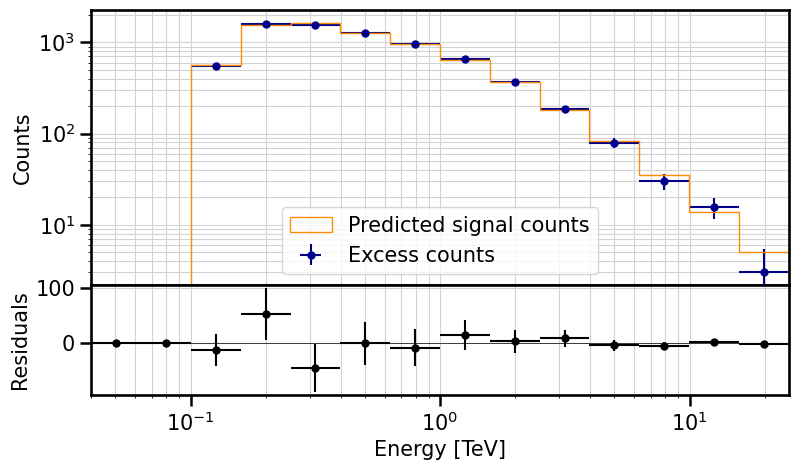

In [10]:
# colors = ['mediumvioletred', 'mediumblue', 'deeppink', 'darkviolet', 'crimson']
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
# plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['legend.frameon'] = False


fig, ax = plt.subplots(figsize=(9, 5))

# plot the number of excess and predicted events
kwargs_residuals = {'color': 'k'}
ax_spectrum, ax_residuals = stacked_dataset.plot_fit(kwargs_residuals=kwargs_residuals)

ax_spectrum.set_ylabel('Counts')
ax_residuals.set_ylabel('Residuals')
ax_spectrum.grid(which='both', color='lightgray')

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid(which='both', color='lightgray')


# plt.savefig(f'{pltpath}migration-matrix-1.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

### Estimating the flux points

We create a `FluxPointsEstimator` object to be applied on our datasets in order to evaluate the SEDs (`sed_type="e2dnde"`)

In [11]:
# create a flux point estimator
flux_points_estimator = FluxPointsEstimator(energy_edges=energy_axis.edges, source=source_name, selection_optional='all')

# Run the flux point estimator to the datasets
print('Running the flux points estimator...')
    
flux_points = flux_points_estimator.run(datasets=stacked_dataset)

# show the flux points table
display(flux_points.to_table(sed_type='e2dnde', formatted=True)[:5])

Running the flux points estimator...


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.050,0.040,0.063,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.080,0.063,0.100,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.126,0.100,0.159,5.308e-11,2.813e-12,2.842e-12,2.786e-12,5.884e-11,530.730,23.038,790.816887056468,556.1321,0.000,False,791.0,True,0.200 .. 5.000,310.727 .. 2400.305
0.200,0.159,0.252,5.476e-11,1.620e-12,1.630e-12,1.609e-12,5.805e-11,1825.952,42.731,2101.9730674956295,1609.6376,0.000,False,2102.0,True,0.200 .. 5.000,1095.159 .. 6478.551
0.317,0.252,0.399,4.713e-11,1.329e-12,1.338e-12,1.319e-12,4.982e-11,2236.608,47.293,1859.0235691849518,1568.6914,0.000,False,1859.0,True,0.200 .. 5.000,1268.001 .. 7380.669


### Computing the SED

Below we show the SEDs for the two datasets in the same plot, showing the flux points and best fit models. For comparison, we plot the Crab reference SED (MAGIC, JHEAp 2015).

### Computing the light curve

For the light curve, we assume that the spectral shape parameters, $\alpha$ and $\beta$, do not change over the different time bins, i.e. we freeze them at their best-fit values achieved above.

In [12]:
frozen_params = ['alpha', 'beta']

sky_model = SkyModel(spectral_model=best_fit_model.copy(), name=source_name)

# freeze the spectral parameters
for param in frozen_params:
    sky_model.parameters[param].frozen = True

# Add the model to the datasets
datasets.models = [sky_model]
print(sky_model)

SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.10e-11   +/- 6.2e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.536                   
    beta                  (frozen):      0.128                   




Now we create a `LightCurveEstimator`.

We must set energy edges and time intervals to be used to compute the light curve. If we adopt `time_intervals=None` we will get a run-wise LC, if instead we give it a list of Astropy Time objects, we can create e.g. a daily binned LC.

In [13]:
energy_edges = energy_axis.edges[[1,-1]]

time_intervals = None # `None` automatically makes a 'run-wise' LC.

# create a light curve estimator
light_curve_estimator = LightCurveEstimator(energy_edges=energy_edges,
                                            time_intervals=time_intervals,
                                            source=source_name,
                                            selection_optional='all'
)

# run the light curve estimator to the datasets

print(f'\nRunning the light curve estimator...')
light_curve = light_curve_estimator.run(datasets=datasets)

# show the light curve table
display(light_curve.to_table(sed_type='flux', format='lightcurve')[:5])


Running the light curve estimator...


time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,44]","float64[1,44]",float64[1],bool[1],"float64[1,44]",bool[1],"float64[1,11]","float64[1,11]"
59171.983648585716,59171.9953684448,1.2584989506418267,0.06335278435066316,24.999999999999996,7.008140872453168e-10,5.0544015679140103e-11,5.143573885430214e-11,4.9666561895402986e-11,8.054966791116624e-10,336.2155803770981,18.336182273774934,302.3424627506552 .. nan,247.12338256835938 .. nan,8.930409211401964,False,302.0 .. nan,True,0.2 .. 4.999999999999999,190.77895232124754 .. 1316.5587968845555
59198.89443178897,59198.90443634765,1.2584989506418267,0.06335278435066316,24.999999999999996,1.1057808922076966e-09,1.0377870026174987e-10,1.0622197696619186e-10,1.0137862575069155e-10,1.3232079138541916e-09,221.16165406302608,14.871504767945511,nan .. nan,nan .. nan,18.961133374174114,False,nan .. nan,True,0.2 .. 4.999999999999999,167.4570555281928 .. 350.78114734308417
59198.90560973238,59198.91539958709,1.2584989506418267,0.06335278435066316,24.999999999999996,8.822085083991355e-10,7.118401652358949e-11,7.267008157563613e-11,6.972352413035474e-11,1.0305722440597151e-09,289.0249498103362,17.000733802113842,nan .. nan,nan .. nan,14.843979651819593,False,nan .. nan,True,0.2 .. 4.999999999999999,192.23178999547216 .. 700.8225433412425
59198.916665688004,59198.92610935184,1.2584989506418267,0.06335278435066316,24.999999999999996,7.596532322492362e-10,6.037544341854618e-11,6.149591929900294e-11,5.930873582618498e-11,8.852274815721852e-10,275.10680781260413,16.5863440158645,nan .. nan,nan .. nan,11.022784233294688,False,nan .. nan,True,0.2 .. 4.999999999999999,167.35261133929333 .. 993.2260743746211
59198.927843031706,59198.93682358211,1.2584989506418267,0.06335278435066316,24.999999999999996,7.843887061275479e-10,6.485880441753388e-11,6.610047186850479e-11,6.363795169089538e-11,9.191254566278114e-10,252.21576158773593,15.88130226359715,nan .. nan,nan .. nan,2.025270272114997,False,nan .. nan,True,0.2 .. 4.999999999999999,149.0632600726993 .. 857.3693440985411


### LC plot

Finally, we plot the LCs and compare them to the Crab reference flux.

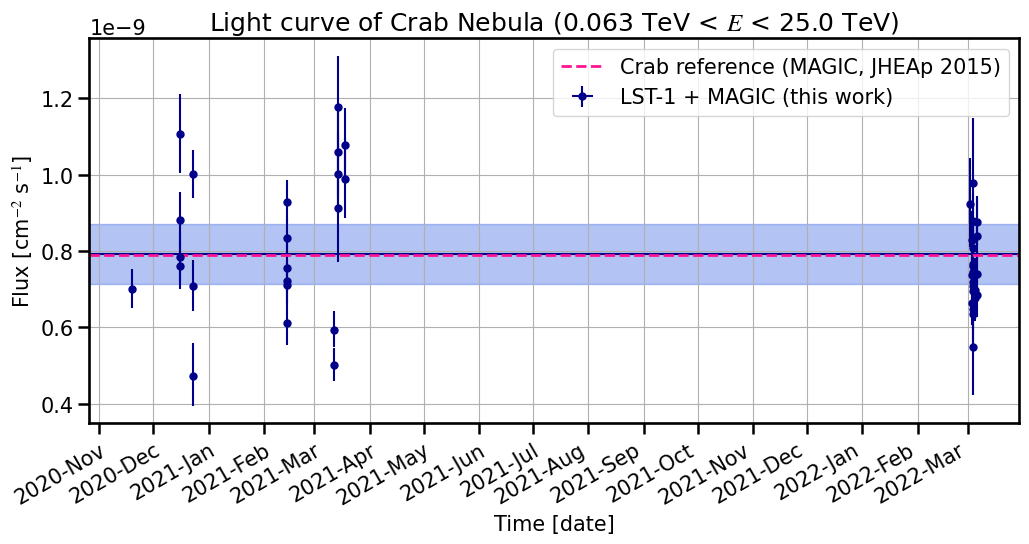

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))

# plot the light curve
light_curve.plot(ax=ax,
                sed_type='flux', 
                label=f'LST-1 + MAGIC (this work)', 
                color=colors[0]
)
    
mean_flux = np.mean(light_curve.to_table(format='lightcurve', sed_type='flux')['flux'])
stdv_flux = np.std(light_curve.to_table(format='lightcurve', sed_type='flux')['flux'])/2
ax.axhline(mean_flux)
ax.axhspan(mean_flux-stdv_flux, mean_flux+stdv_flux, color='royalblue', alpha=0.4)

    
# plot the reference flux
for label, model in reference_models.items():
    
    integ_flux = model.integral(energy_edges[0], energy_edges[1])
    ax.axhline(integ_flux, label=label, linestyle='--', lw=2, color='deeppink')
    
energy_range = f'{energy_edges[0]:.3f} < $E$ < {energy_edges[1]:.1f}'

ax.set_title(f'Light curve of {source_name} ({energy_range})')
ax.set_ylabel('Flux [cm$^{-2}$ s$^{-1}$]')
ax.set_xlabel('Time [date]')

# ax.set_xlim(18570, 18590)
ax.legend()
ax.set_yscale('linear')
ax.grid()

ax.xaxis.set_major_locator(MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))

plt.show()

In [15]:
table_LC = light_curve.to_table(sed_type='flux', format='lightcurve')
flux     = np.array(table_LC['flux'], dtype=float) 
flux     = np.array([f[0] for f in flux]) * 1e9
flux_err = np.array(table_LC['flux_err'], dtype=float) 
flux_err = np.array([f[0] for f in flux_err]) * 1e9
time     = np.array(table_LC['time_min'], dtype=float)

reference_date = datetime(1858, 11, 17)
delta = [timedelta(days=t) for t in time]
date  = [reference_date + d for d in delta]

mean_flux = np.mean(flux)
stdv_flux = np.std(flux)

/fefs/aswg/software/conda/envs/gammapy-v1.0/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Light curve (          63 GeV < $E$ < 25 TeV)


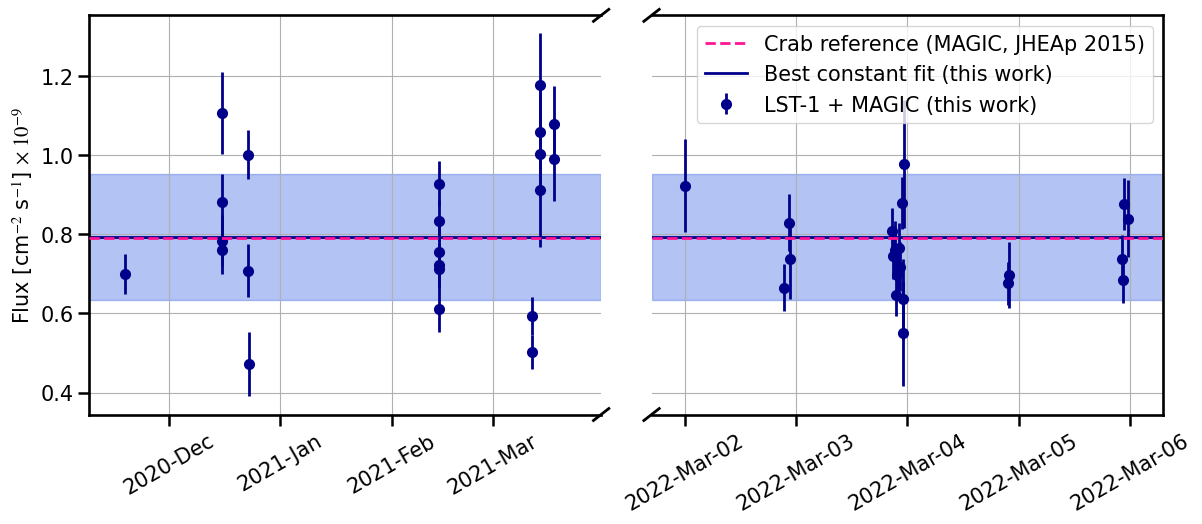

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5), sharey=True)

for ax in [ax1, ax2]:
    # plot the light curve
    ax.errorbar(date, flux, yerr=flux_err, marker='o', lw=2, ls='', color=colors[0], label=f'LST-1 + MAGIC (this work)')

    # plot the reference flux
    for label, model in reference_models.items():

        integ_flux, integ_flux_error = np.array(model.integral_error(energy_edges[0], energy_edges[1]).value) * 1e9
        
        ax.axhline(integ_flux, label=label, linestyle='--', color='deeppink', lw=2, zorder=10)
        ax.axhspan(integ_flux-integ_flux_error, integ_flux+integ_flux_error, color='deeppink', alpha=0.4)
        
    ax.axhline(mean_flux, lw=2, label='Best constant fit (this work)')
    ax.axhspan(mean_flux-stdv_flux, mean_flux+stdv_flux, color='royalblue', alpha=0.4)
    ax.grid()

    ax.xaxis.set_tick_params(rotation=30)

energy_range = f'          {energy_edges[0].to(u.GeV):.0f} < $E$ < {energy_edges[1]:.0f}'
print(f'Light curve ({energy_range})')
# fig.suptitle(f'{energy_range}')
ax1.set_ylabel('Flux [cm$^{-2}$ s$^{-1}$] $\\times \ 10^{-9}$')
ax2.set_ylabel('')

ax1.xaxis.set_major_locator(MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%b'))
ax2.xaxis.set_major_locator(DayLocator(interval=1))
ax2.xaxis.set_major_formatter(DateFormatter('%Y-%b-%d'))
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

for tick in ax2.yaxis.get_major_ticks():
    tick.tick1line.set_visible(False); tick.tick2line.set_visible(False)
    tick.label1.set_visible(False); tick.label2.set_visible(False)
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, lw=2)
ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

fig.subplots_adjust(wspace=-1)

ax1.set_xlim(18575, 18717)
ax2.set_xlim(19052.7, 19057.3)

ax2.legend()

fig.tight_layout()

plt.savefig(f'{pltpath}Crab-flux.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

In [17]:
mean_flux, stdv_flux

(0.7921712427150783, 0.15913879065570813)

In [18]:
integ_flux, integ_flux_error

(0.7901025693504649, 0.0)

## Multimesures plot

## Extract extra points
- energy
- flux
- flux error

In [19]:
extra_points_file = '/fefs/aswg/workspace/juan.jimenez/data/other_results/CrabNebula_spectrum.ecsv'
df_extra = pd.read_csv(extra_points_file, sep=' ', comment='#')

df_extra['energy'] = df_extra['energy'] * 1e6

paper_abvr = ['baars', 'macias', 'mezger', 'bandiera', 'kirshner', 'hennessy', 'xmm', 'spi', 'fermi_33months', 'magic', 'hegra', 'hess']

extra_flux_series = {'baars':'Baars & Hartsuijker (1972)',
                    'macias':'Macías-Pérez et al. (2010)',
                    'mezger':'P.G. Mezger et al. (1986)',
                    'bandiera':'R. Bandiera et al. (2002)',
                    'kirshner':'R.P. Kirshner (1974)',
                    'hennessy':'G.S. Hennessy et al. (1992)',
                    'xmm':'R. Willingale et al. (2000)',
                    'spi':'E. Jourdain & J. P. Roques (2009)',
                    'fermi_33months':'A.A. Abdo et al. (2010)',
                    'magic':'J. Aleksić et al. (2015)',
                    'hegra':'F.A. Aharonian et al. (2000)',
                    'hess':'F.A. Aharonian et al. (2006)'}
extra_flux_series = {'baars':'Baars et al. (1972) & Macías et al. (2010)',
                    'macias':None,
                    'mezger':'Mezger et al. (1986) & Bandiera et al. (2002)',
                    'bandiera':None,
                    'kirshner':'Kirshner (1974) & Hennessy et al. (1992)',
                    'hennessy':None,
                    'xmm':'R. Willingale et al. (2000)',
                    'spi':'E. Jourdain & J. P. Roques (2009)',
                    'fermi_33months':'Fermi-LAT (A.A. Abdo et al. 2010)',
                    'magic':'MAGIC (J. Aleksić et al. 2015)',
                    'hegra':'HEGRA (F.A. Aharonian et al. 2000)',
                    'hess':'HESS (F.A. Aharonian et al. 2006)'}

extra_flux_colors = {'baars':'maroon',
                    'macias':'maroon',
                    'mezger':'crimson',
                    'bandiera':'crimson',
                    'kirshner':'#01D776',
                    'hennessy':'#01D776',
                    'xmm':'#00D6C2',
                    'spi':'#00ffff',
                    'fermi_33months':'cornflowerblue',
                    'magic':'c',
                    'hegra':'darkviolet',
                    'hess':'g'}

e_extra = [df_extra[df_extra['paper'] == p]['energy'].to_numpy(dtype=float) for p in paper_abvr]
labels_extra = [extra_flux_series[p] for p in paper_abvr]                      
colors_extra = [extra_flux_colors[p] for p in paper_abvr]
e2dnde_extra = [df_extra[df_extra['paper'] == p]['flux'].to_numpy(dtype=float) for p in paper_abvr]
e2dnde_err_extra = [df_extra[df_extra['paper'] == p]['flux_error'].to_numpy(dtype=float) for p in paper_abvr]

## Reading fermi data

In [20]:
fermi_flux_points = FluxPoints.read(fermi_lat_sed_file)
table_fer = fermi_flux_points.to_table(sed_type='e2dnde', formatted=True)

e_fer = u.Quantity(table_fer['e_ref'], 'MeV').to('TeV')

e_edges_fer = geom.compute_bin_edges(e_fer.value)*u.TeV
e_err_fer   = (e_edges_fer[:-1] + e_edges_fer[1:]) / 2

e2dnde_fer         = u.Quantity(table_fer['e2dnde'],     'MeV / (cm2 s)').to('erg / (cm2 s)')
e2dnde_err_fer     = u.Quantity(table_fer['e2dnde_err'], 'MeV / (cm2 s)').to('erg / (cm2 s)')

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


# Extracting this work experimental datapoints (d1)

In [21]:
table_lp1 = flux_points.to_table(sed_type='e2dnde', formatted=True)

e_d1 = u.Quantity(table_lp1['e_ref'], 'TeV')

e_left_d1 = u.Quantity(table_lp1['e_min'], 'TeV')
e_right_d1 = u.Quantity(table_lp1['e_max'], 'TeV')
e_err_d1 = [e_d1 - e_left_d1, e_right_d1 - e_d1]

e2dnde_d1     = u.Quantity(table_lp1['e2dnde'],     'TeV / (cm2 s)').to('erg / (cm2 s)')
e2dnde_err_d1 = u.Quantity(table_lp1['e2dnde_err'], 'TeV / (cm2 s)').to('erg / (cm2 s)')

fit_params_lp1 = best_fit_model.parameters.value
fit_params_lp1 = [u.Quantity(fit_params_lp1[0], '1 / (cm2 s TeV)'), 1*u.TeV, fit_params_lp1[2], fit_params_lp1[3]]

e2dnde_lp1 =  e_d1 * e_d1 * model.evaluate(e_d1, *fit_params_lp1)

residuals_lp1     = (e2dnde_lp1.to('TeV / (cm2 s)') - e2dnde_d1.to('TeV / (cm2 s)')) / e2dnde_d1.to('TeV / (cm2 s)') * 100
residuals_err_lp1 = e2dnde_err_d1 / e2dnde_d1 * 100

print(f'Log Par fit-1 parameters: {fit_params_lp1}')

Log Par fit-1 parameters: [<Quantity 3.10433176e-11 1 / (cm2 s TeV)>, <Quantity 1. TeV>, 2.536325143186535, 0.1279864739770464]


In [22]:
cov = best_fit_model.covariance.data
np.sqrt(np.diagonal(cov))

array([6.19585858e-13, 0.00000000e+00, 1.85304694e-02, 1.19222803e-02])

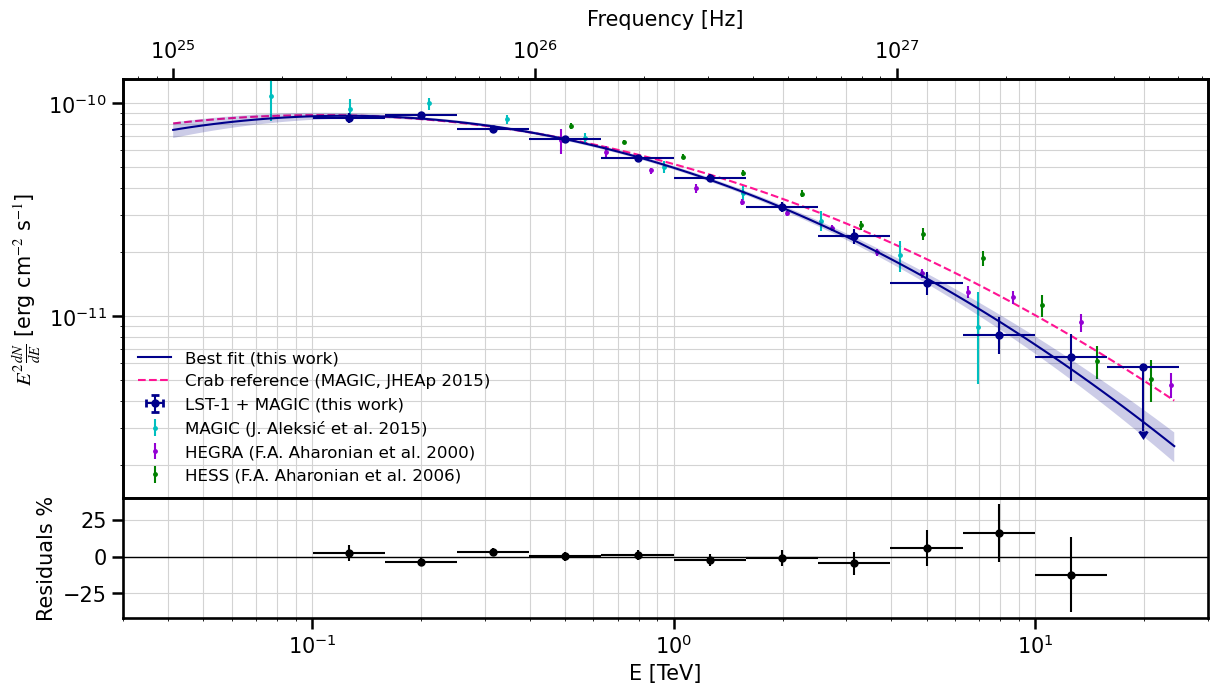

In [23]:
#############################################
energy_bounds = energy_axis.edges[[0, -1]]

#############################################

fig, (ax1, axb1) = plt.subplots(2, 1, figsize=(14, 7), gridspec_kw={'height_ratios': [3.5, 1]})


# --- flux points --- #
flux_points.plot(ax=ax1,
                 sed_type=sed_type, 
                 label=f'LST-1 + MAGIC (this work)',
                 color=colors[0],
                 zorder=5
)


# --- best fit model --- #
best_fit_model.plot(ax=ax1,
                    energy_bounds=energy_bounds,
                    sed_type=sed_type,
                    yunits=yunits,
                    color=colors[0],
                    label='Best fit (this work)',
                    zorder=5
)

# --- best fit model error --- #
best_fit_model.plot_error(ax=ax1,
                          energy_bounds=energy_bounds,
                          sed_type=sed_type,
                          yunits=yunits,
                          facecolor=colors[0],
                          zorder=4
)


# --- reference spectra --- #
for label, model in reference_models.items():
    model.plot(ax=ax1,
               energy_bounds=energy_bounds,
               sed_type=sed_type,
               yunits=yunits,
               label=label,
               linestyle='--',
               color='deeppink'
              )
    
# --- other data points to plot --- #
for i in range(len(e_extra)):
    if paper_abvr[i] in ['hess', 'hegra', 'magic']:
        ax1.errorbar(e_extra[i]*1e-12, e2dnde_extra[i], yerr=e2dnde_err_extra[i], label=labels_extra[i],
                    marker='.', ls='', color=colors_extra[i], zorder=3, ms=3)
        

# --- error --- #
axb1.errorbar(e_d1[:-1], residuals_lp1[:-1], yerr=residuals_err_lp1[:-1], xerr=[e_err_d1[0][:-1], e_err_d1[1][:-1]], 
             marker='.', ms=8, ls='', color='k') 
axb1.axhline(0, color='k', ls='-', lw=1)


# twin axes ############
axt1 = ax1.twiny() 

# plot limits ##########
xlimsE = np.array([0.03, 30])
xlimsV = xlimsE * 2.418e14 * 1e12
for axe in [ax1, axb1]:
    axe.set_xlim(*xlimsE)
ax1.loglog()
axb1.set_xscale('log')
axt1.set_xlim(*xlimsV)

ax1.set_ylim(1.4e-12, 1.3e-10)
axt1.set_xscale('log')

# labels ###############
ax1.set_ylabel('$E^2\\frac{dN}{dE}$ [erg cm$^{-2}$ s$^{-1}$]')
axt1.set_xlabel('Frequency [Hz]', labelpad=10)
axb1.set_ylabel('Residuals %')
axb1.set_xlabel('E [TeV]')

# legends ##############
for axe in [ax1, axb1]:
    axe.grid(which='both', color='lightgray')
ax1.legend(loc='lower left', fontsize=12, frameon=False)

# ticks ################
ax1.set_xticklabels([])


fig.subplots_adjust(wspace=0, hspace=0)


plt.savefig(f'{pltpath}logpar-thiswork.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

## Creating and fitting a dataset Fermi+This work (d2)

In [24]:
# joint points
e_d2 = np.concatenate([e_fer[:-1], e_d1[2:]])[6:-4]

# temporal assignment
e_err_right_f = e_err_fer                                 
e_err_left_f  = geom.compute_left_errors(e_fer.value, e_err_fer.value)*u.TeV 
e_err_left_f, e_err_right_f = geom.compute_left_right_errors(e_fer.value)
e_err_left_f, e_err_right_f = e_err_left_f*u.TeV, e_err_right_f*u.TeV


e_err_right_d2 = np.concatenate([e_err_right_f[:-1], e_err_d1[1][2:]])[6:-4]
e_err_left_d2  = np.concatenate([e_err_left_f[:-1],  e_err_d1[0][2:]])[6:-4]
e_err_d2       = [e_err_left_d2, e_err_right_d2]

e2dnde_d2     = u.Quantity(np.concatenate([e2dnde_fer[:-1], e2dnde_d1[2:]])[6:-4], 'erg / (cm2 s)').to('TeV / (cm2 s)')
e2dnde_err_d2 = u.Quantity(np.concatenate([e2dnde_err_fer[:-1], e2dnde_err_d1[2:]])[6:-4], 'erg / (cm2 s)').to('TeV / (cm2 s)')

# finding the best fit parameters
fit_params_lp2, cov = curve_fit(geom.logpar, e_d2.value, e2dnde_d2.value, p0=best_fit_model.parameters.value)
fit_params_lp2      = [u.Quantity(fit_params_lp2[0], '1 / (cm2 s TeV)'), 1*u.TeV, fit_params_lp2[2], fit_params_lp2[3]]
fit_params_lp2_err  = np.sqrt(np.diagonal(cov))
fit_params_lp2_err  = [u.Quantity(fit_params_lp2_err[0], '1 / (cm2 s TeV)'), fit_params_lp2_err[1]*u.TeV, fit_params_lp2_err[2], fit_params_lp2_err[3]]

e2dnde_lp2 =  e_d2 * e_d2 * model.evaluate(e_d2, *fit_params_lp2)

residuals_lp2     = (e2dnde_lp2.to('TeV / (cm2 s)') - e2dnde_d2.to('TeV / (cm2 s)')) / e2dnde_d2.to('TeV / (cm2 s)') * 100
residuals_err_lp2 = e2dnde_err_d2 / e2dnde_d2 * 100

print(f'Log Par fit-2 parameters: {fit_params_lp2}')

Log Par fit-2 parameters: [<Quantity 2.94218353e-11 1 / (cm2 s TeV)>, <Quantity 1. TeV>, 2.493281824022645, 0.0860556287342863]


In [25]:
fit_params_lp2_err

[<Quantity 0.000779 1 / (cm2 s TeV)>,
 <Quantity 11023752.7828382 TeV>,
 1828847.0307556237,
 0.029501340328277142]

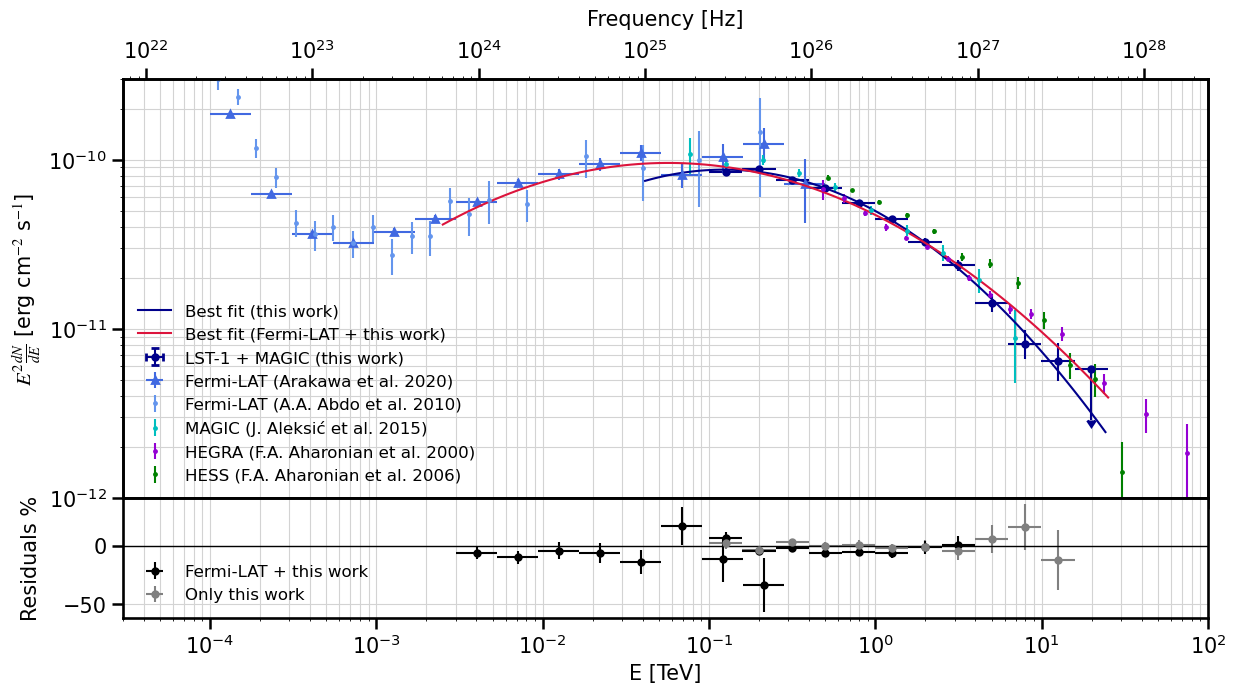

In [43]:
#############################################
energy_bounds = energy_axis.edges[[0, -1]]

e_lspace = np.logspace(-2.6, 1.4, 100) * u.TeV
#############################################

fig, (ax1, axb1) = plt.subplots(2, 1, figsize=(14, 7), gridspec_kw={'height_ratios': [3.5, 1]})

# --- flux points --- #
flux_points.plot(ax=ax1,
                    sed_type=sed_type, 
                    label=f'LST-1 + MAGIC (this work)',
                    color=colors[0],
)

# --- best fit model --- #
best_fit_model.plot(ax=ax1,
                    energy_bounds=energy_bounds,
                    sed_type=sed_type,
                    yunits=yunits,
                    color=colors[0],
                    label='Best fit (this work)'
)


# --- fermi reference --- #
fermi_flux_points.plot(
                    label='Fermi-LAT (Arakawa et al. 2020)',
                    color='royalblue',
                    marker='^',
                    zorder=3,
                    sed_type='e2dnde',
                    ax=ax1,
                    markersize=4
)
    
# --- plot the new fit with joint data --- #
ax1.plot(e_lspace.value, (e_lspace * e_lspace * best_fit_model.evaluate(e_lspace, *fit_params_lp2)).to('erg / (cm2 s)'), 
        color='crimson',
        label='Best fit (Fermi-LAT + this work)')

# --- plot extra experimental points --- #
for i in range(len(e_extra)):
    if paper_abvr[i] in ['fermi_33months', 'hess', 'hegra', 'magic']:
        ax1.errorbar(e_extra[i]*1e-12, e2dnde_extra[i], yerr=e2dnde_err_extra[i], label=labels_extra[i],
                    marker='.', ls='', color=colors_extra[i], zorder=3, ms=3)

# --- error --- #
axb1.errorbar(e_d2, residuals_lp2, yerr=residuals_err_lp2, xerr=e_err_d2, marker='.', ms=8, ls='', color='k', label='Fermi-LAT + this work', zorder=4) 
axb1.axhline(0, color='k', ls='-', lw=1, zorder=1)
axb1.errorbar(e_d1[:-1], residuals_lp1[:-1], yerr=residuals_err_lp1[:-1], xerr=[e_err_d1[0][:-1], e_err_d1[1][:-1]], 
             marker='.', ms=8, ls='', color='gray', zorder=3, label='Only this work')


# twin axes ############
axt1 = ax1.twiny() 

# plot limits ##########
xlimsE = np.array([3e-5, 1e2])
xlimsV = xlimsE * 2.418e14 * 1e12
for axe in [ax1, axb1]:
    axe.set_xlim(*xlimsE)
ax1.loglog()
axb1.set_xscale('log')
axt1.set_xlim(*xlimsV)

ax1.set_ylim(1e-12, 3e-10)
axt1.set_xscale('log')

# labels ###############
ax1.set_ylabel('$E^2\\frac{dN}{dE}$ [erg cm$^{-2}$ s$^{-1}$]')
axt1.set_xlabel('Frequency [Hz]', labelpad=10)
axb1.set_ylabel('Residuals %', labelpad=16)
axb1.set_xlabel('E [TeV]')

# legends ##############
for axe in [ax1, axb1]:
    axe.grid(which='both', color='lightgray', zorder=-100)
    axe.legend(loc='lower left', fontsize=12, frameon=False)

# ticks ################
ax1.set_xticklabels([])
[line.set_zorder(100) for line in ax1.lines]
[line.set_zorder(100) for line in axb1.lines]

fig.subplots_adjust(wspace=0, hspace=0)


plt.savefig(f'{pltpath}logpar-fermi.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

In [27]:
fit_params_lp0 = model.parameters.value
fit_params_lp0 = [u.Quantity(fit_params_lp0[0], '1 / (cm2 s TeV)'), 1*u.TeV, fit_params_lp0[2], fit_params_lp0[3]]

def ff0(e):
    return e * e * best_fit_model.evaluate(e*u.TeV, *fit_params_lp0)

def ff1(e):
    return e * e * best_fit_model.evaluate(e*u.TeV, *fit_params_lp1)

def ff2(e):
    return e * e * best_fit_model.evaluate(e*u.TeV, *fit_params_lp2)

max0 = optimize.fmin(lambda x: -ff0(x), 1)[0]
max1 = optimize.fmin(lambda x: -ff1(x), 1)[0]
max2 = optimize.fmin(lambda x: -ff2(x), 1)[0]

print(f'\n\nPeak of parabola at:\nReference\t\t-->\t{max0:.3f}\nMAGIC+LST-1\t\t-->\t{max1:.3f} TeV\nFermi+MAGIC+LST-1\t-->\t{max2:.3f} TeV')

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 18
         Function evaluations: 36


Peak of parabola at:
Reference		-->	0.105
MAGIC+LST-1		-->	0.123 TeV
Fermi+MAGIC+LST-1	-->	0.057 TeV


/fefs/aswg/software/conda/envs/gammapy-v1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## Constructing the model SYNC+IC
- The log function for the fit
- And th emodel function

In [28]:
def SYN_IC_LOG(energy, ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1, Bmag=1):
    energy=10**energy
    energy = u.Quantity(energy, 'eV')
    ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, 
                                            alpha_1=a1*1.5, alpha_2=a2*3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0,)
    eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}
    SYN = Synchrotron(ECBPL, B=Bmag*125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)
    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24
    IC = InverseCompton(ECBPL, seed_photon_fields=['CMB', ['FIR', 70 * u.K, 0.5 * u.eV / u.cm ** 3], ['NIR', 5000 * u.K, 1 * u.eV / u.cm ** 3], ['SSC', Esy, phn_sy],],
                        Eemax=50 * u.PeV, Eemin=0.1 * u.GeV,)    
    return np.log10((IC.sed(energy, 2 * u.kpc) + SYN.sed(energy, 2 * u.kpc)).value)

def SYN_IC(energy, ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1, Bmag=1):
    
    ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, 
                                            alpha_1=a1*1.5, alpha_2=a2*3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0,)

    eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

    SYN = Synchrotron(ECBPL, B=Bmag*125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

    IC = InverseCompton(ECBPL, seed_photon_fields=['CMB', ['FIR', 70 * u.K, 0.5 * u.eV / u.cm ** 3], ['NIR', 5000 * u.K, 1 * u.eV / u.cm ** 3], ['SSC', Esy, phn_sy],],
                        Eemax=50 * u.PeV, Eemin=0.1 * u.GeV,)    
    
    return IC.sed(energy, 2 * u.kpc) + SYN.sed(energy, 2 * u.kpc)


def ECBPL_electrons(energy, ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1):
    
    return ExponentialCutoffBrokenPowerLaw.eval(e=energy, amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, 
                      alpha_1=a1*1.5, alpha_2=a2*3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0,)

def IC_only(ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1, Bmag=1):
    
    ECBPL = ExponentialCutoffBrokenPowerLaw(
        amplitude=ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, alpha_1=a1 * 1.5, alpha_2=a2 * 3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0)
    eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

    SYN = Synchrotron(ECBPL, B=Bmag * 125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

    IC = InverseCompton(
        ECBPL,
        seed_photon_fields=[
            'CMB',
            ['FIR', 70 * u.K, 0.5 * u.eV / u.cm ** 3],
            ['NIR', 5000 * u.K, 1 * u.eV / u.cm ** 3],
            ['SSC', Esy, phn_sy],
        ],
        Eemax=50 * u.PeV,
        Eemin=0.1 * u.GeV,)
    return IC

## Building a total dataset to fit SYN+IC (d3)

In [29]:
perform_fit = False

aux.createdir('data')

e_d3 = np.concatenate([np.concatenate(e_extra)[:-30], e_d1.to('eV')[2:-1].value])*u.eV

e2dnde_d3 = u.Quantity(np.concatenate([np.concatenate(e2dnde_extra)[:-30], e2dnde_d1.to('erg / (cm2 s)')[2:-1].value]), 'erg / (cm2 s)')
e2dnde_err_d3 = u.Quantity(np.concatenate([np.concatenate(e2dnde_err_extra)[:-30], e2dnde_err_d1.to('erg / (cm2 s)')[2:-1].value]), 'erg / (cm2 s)')


if perform_fit == True:
    fit_params_d3, fit_params_d3_cov = curve_fit(SYN_IC_LOG, np.log10(e_d3.value), np.log10(e2dnde_d3.value), sigma=np.log10(e2dnde_err_d3.value), p0=np.repeat(1, 7), bounds=[np.repeat(0.5, 7), np.repeat(2, 7)])
    np.savetxt(f'data/fit_params_d3_{source_name}.txt', fit_params_d3)
    np.savetxt(f'data/fit_params_d3_cov_{source_name}.txt', fit_params_d3_cov)

fit_params_d3 = np.loadtxt(f'data/fit_params_d3_{source_name}.txt')
fit_params_d3_cov = np.loadtxt(f'data/fit_params_d3_cov_{source_name}.txt')


for fp, name in zip([np.repeat(1, 7), fit_params_d3], ['Naima', 'This Work']):
    print(f'\nOPTIMAL PARAMETERS for {name}:\nFor the electron distribution:\nAmplitude\t\t= {fp[0]* 3.699e36 / u.eV:.4e}\nalpha before break\t= {fp[1]*1.5:.4f}')
    print(f'alpha after break\t= {fp[2]*3.233:.4f}\nbeta\t\t\t= {fp[3]* 2.0:.4f}\ncutoff energy\t\t= {fp[4] * 1863 * u.TeV:.4f}')
    print(f'break energy\t\t= {fp[5]* 0.265 * u.TeV:.4f}\nOthers:\nMagnetic Field\t\t={fp[6]*125 * u.uG:.4f}')
    
e2dnde_syncic_1 =  SYN_IC(e_d3, *fit_params_d3)
e2dnde_syncic_naima =  SYN_IC(e_d3, *np.repeat(1, 7))

residuals_syncic_1     = (e2dnde_syncic_1.to('eV / (cm2 s)') - e2dnde_d3.to('eV / (cm2 s)')) / e2dnde_d3.to('eV / (cm2 s)') * 100
residuals_err_syncic_1 = e2dnde_err_d3 / e2dnde_d3 * 100

residuals_syncic_naima     = (e2dnde_syncic_naima.to('eV / (cm2 s)') - e2dnde_d3.to('eV / (cm2 s)')) / e2dnde_d3.to('eV / (cm2 s)') * 100
residuals_err_syncic_naima = e2dnde_err_d3 / e2dnde_d3 * 100


OPTIMAL PARAMETERS for Naima:
For the electron distribution:
Amplitude		= 3.6990e+36 1 / eV
alpha before break	= 1.5000
alpha after break	= 3.2330
beta			= 2.0000
cutoff energy		= 1863.0000 TeV
break energy		= 0.2650 TeV
Others:
Magnetic Field		=125.0000 uG

OPTIMAL PARAMETERS for This Work:
For the electron distribution:
Amplitude		= 1.9435e+36 1 / eV
alpha before break	= 1.6366
alpha after break	= 3.2313
beta			= 1.3707
cutoff energy		= 1577.8059 TeV
break energy		= 0.3759 TeV
Others:
Magnetic Field		=119.3333 uG


In [30]:
cov = fit_params_d3_cov
e = np.sqrt(np.diagonal(cov))

print(f'\nOPTIMAL PARAMETERS for {name}:\nFor the electron distribution:\nAmplitude\t\t= {e[0]* 3.699e36 / u.eV:.4e}\nalpha before break\t= {e[1]*1.5:.4f}')
print(f'alpha after break\t= {e[2]*3.233:.4f}\nbeta\t\t\t= {e[3]* 2.0:.4f}\ncutoff energy\t\t= {e[4] * 1863 * u.TeV:.4f}')
print(f'break energy\t\t= {e[5]* 0.265 * u.TeV:.4f}\nOthers:\nMagnetic Field\t\t={e[6]*125 * u.uG:.4f}')
    


OPTIMAL PARAMETERS for This Work:
For the electron distribution:
Amplitude		= 1.4622e+35 1 / eV
alpha before break	= 0.0176
alpha after break	= 0.0090
beta			= 0.1668
cutoff energy		= 170.7279 TeV
break energy		= 0.0234 TeV
Others:
Magnetic Field		=2.8782 uG


Converting to eV (this work)

In [31]:
table = flux_points.to_table(sed_type='e2dnde', formatted=True)

# change to eV
for lab in ['e_ref', 'e_min', 'e_max']:
    table[lab] = table[lab].to('eV')
table[:5]

flux_points_eV = FluxPoints.from_table(table, sed_type='e2dnde')

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


## Total plot

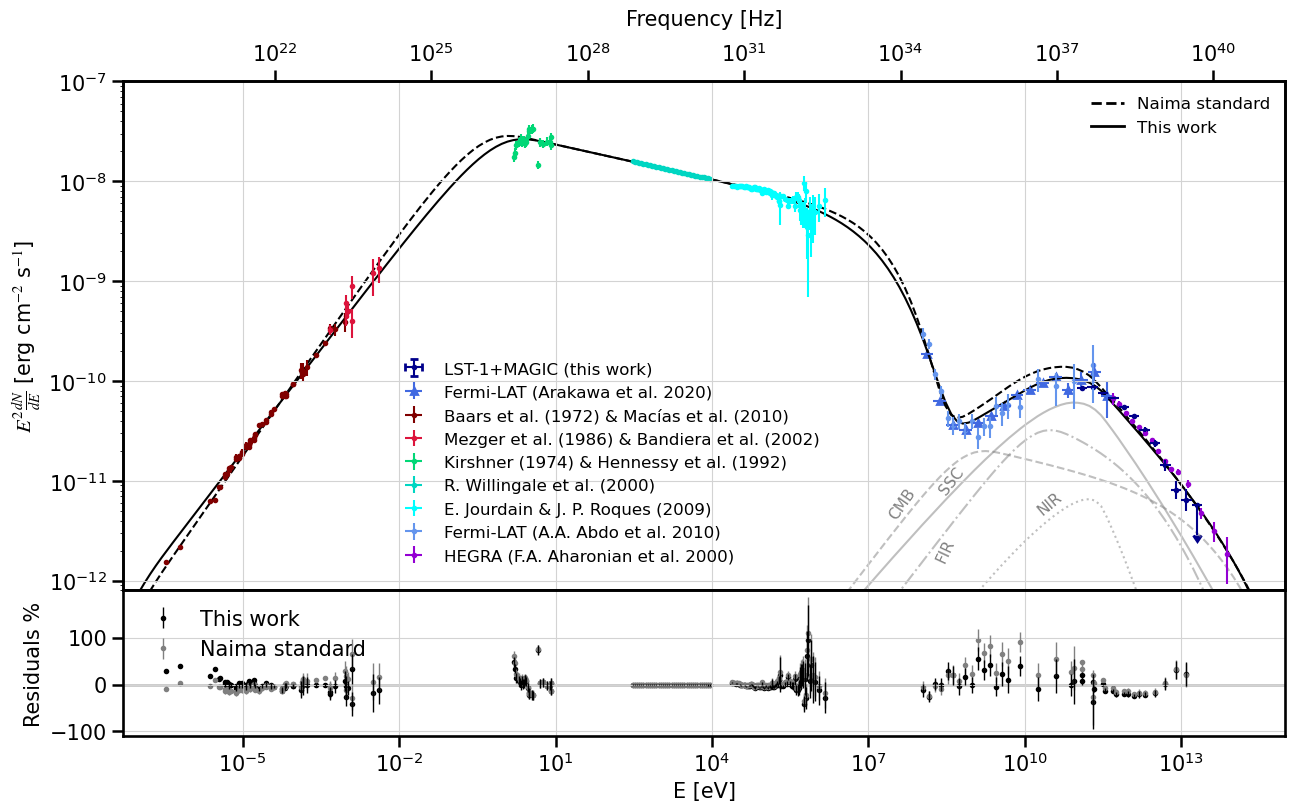

In [32]:
##############################################

energy = np.logspace(-7, 15, 200) * u.eV
energy_bounds = energy_axis.edges[[0, -1]]

##############################################


fig, (ax1, axb1) = plt.subplots(2, 1, figsize=(15, 8.5), gridspec_kw={'height_ratios': [3.5, 1]})

# --- flux points --- #
flux_points_eV.plot(ax=ax1,
                  sed_type=sed_type, 
                  label=f'LST-1+MAGIC (this work)',
                  color=colors[0],
                  zorder=100,
                  marker='.'
)

# --- fermi reference --- #
fermi_flux_points.plot(
    label='Fermi-LAT (Arakawa et al. 2020)',
    color='royalblue',
    marker='^',
    zorder=-3,
    sed_type='e2dnde',
    ax=ax1,
)

# --- computed model emission --- #
ax1.plot(energy, SYN_IC(energy, *fit_params_d3),
    lw=1.5, c='k', zorder=-10,
)
ax1.plot(energy, SYN_IC(energy, *np.repeat(1, 7)),
    lw=1.5, c='k', ls='--', zorder=-10,
)

# --- components of the SI --- #
for i, seed, ls in zip(range(4), ['CMB', 'FIR', 'NIR', 'SSC'], ['--', '-.', ':', '-']):
    ax1.loglog(energy, IC_only(*fit_params_d3).sed(energy, 2 * u.kpc, seed=seed),
        lw=1.5, c='gray', ls=ls, zorder=-1, alpha=0.5,
    )

# --- plotting extra data --- #
for i in range(len(e_extra)):
    if paper_abvr[i] not in ['hess', 'magic']:
        ax1.errorbar(e_extra[i], e2dnde_extra[i], yerr=e2dnde_err_extra[i], xerr=0, label=labels_extra[i],
                    marker='o', ls='', color=colors_extra[i], zorder=10, ms=2)

        
# --- labeling IC components --- #
ax1.text(4.5e7, 6e-12, 'CMB', color='gray', fontsize=11, rotation=55, ha='center', va='center')
ax1.text(4e8, 1e-11, 'SSC', color='gray', fontsize=11, rotation=52, ha='center', va='center')
ax1.text(3e8, 2e-12, 'FIR', color='gray', fontsize=11, rotation=65, ha='center', va='center')
ax1.text(3e10, 6e-12, 'NIR', color='gray', fontsize=11, rotation=40, ha='center', va='center')

# --- error --- #
axb1.errorbar(e_d3, residuals_syncic_1, yerr=residuals_err_syncic_1, marker='.', ms=4, ls='', color='k', lw=1, label='This work', zorder=10) 
axb1.errorbar(e_d3, residuals_syncic_naima, yerr=residuals_err_syncic_naima, marker='.', ms=4, ls='', color='gray', lw=1,label='Naima standard', zorder=6) 
axb1.axhline(0, color='k', ls='-', lw=1, zorder=0)


# twin axes ############
axt1 = ax1.twiny() 

# plot limits ##########
xlimsE = np.array([5e-8, 1e15])
xlimsV = xlimsE * 2.418e14 * 1e12
for axe in [ax1, axb1]:
    axe.set_xlim(*xlimsE)
ax1.loglog()
axb1.set_xscale('log')
axt1.set_xlim(*xlimsV)

ax1.set_ylim(8e-13, 1e-7)
axt1.set_xscale('log')

# labels ###############
ax1.set_ylabel('$E^2\\frac{dN}{dE}$ [erg cm$^{-2}$ s$^{-1}$]')
axt1.set_xlabel('Frequency [Hz]', labelpad=12)
axb1.set_ylabel('Residuals %')
axb1.set_xlabel('E [eV]')

# legends ##############
for axe in [ax1, axb1]:
    axe.grid(color='lightgray')
    [line.set_zorder(-10) for line in axe.lines]
ax1.legend(loc=(0.23, 0.04), fontsize=12, frameon=False)
axb1.legend(loc=2, frameon=False)
axt1.plot([], [], lw=2, color='k', ls='--', label='Naima standard', zorder=0)
axt1.plot([], [], lw=2, color='k', ls='-', label='This work', zorder=0)
axt1.legend(loc=1, frameon=False, fontsize=12)

# ticks ################
ax1.set_xticklabels([])
axb1.set_yticks([-100, 0, 100])
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig(f'{pltpath}multiwavelength-fit.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

In [33]:
table_vhe  = table[2:].copy()
df_tm = df_extra.query(f'paper != "ma"')#paper == "spi" or paper == "xmm"

table_vhe['energy'] = table_vhe['e_ref']
table_vhe['flux'] = table_vhe['e2dnde']
table_vhe['flux_error'] = table_vhe['e2dnde_err']

table_xray = table_vhe.copy()

for i in range(len(df_tm)-len(table_vhe)):
    table_xray.add_row(np.repeat(0, 21))
    
ee = df_tm['energy']
ff = df_tm['flux']
fe = df_tm['flux_error']

table_xray['energy'] = ee*u.TeV
table_xray['flux']   = ff
table_xray['flux_error'] = fe

table_xray['energy'].unit = u.eV
table_xray['flux'].unit = u.erg / u.s / u.cm / u.cm
table_xray['flux_error'].unit = u.erg / u.s / u.cm / u.cm

In [34]:
naima.estimate_B(table_xray[79:-57], table_vhe)

<Quantity 91.06645975 uG>

In [35]:
def trapz_loglog(y, x, axis=-1, intervals=False):
    try:
        y_unit = y.unit
        y = y.value
    except AttributeError:
        y_unit = 1.0
    try:
        x_unit = x.unit
        x = x.value
    except AttributeError:
        x_unit = 1.0

    y = np.asanyarray(y)
    x = np.asanyarray(x)

    slice1 = [slice(None)] * y.ndim
    slice2 = [slice(None)] * y.ndim
    slice1[axis] = slice(None, -1)
    slice2[axis] = slice(1, None)

    slice1 = tuple(slice1)
    slice2 = tuple(slice2)

    if x.ndim == 1:
        shape = [1] * y.ndim
        shape[axis] = x.shape[0]
        x = x.reshape(shape)

    # Compute the power law indices in each integration bin
    b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])

    # if local powerlaw index is -1, use \int 1/x = log(x); otherwise use
    # normal powerlaw integration
    trapzs = np.where(
        np.abs(b + 1.0) > 1e-10,
        (
            y[slice1]
            * (x[slice2] * (x[slice2] / x[slice1]) ** b - x[slice1])
        )
        / (b + 1),
        x[slice1] * y[slice1] * np.log(x[slice2] / x[slice1]),
    )

    tozero = (y[slice1] == 0.0) + (y[slice2] == 0.0) + (x[slice1] == x[slice2])
    trapzs[tozero] = 0.0

    if intervals:
        return trapzs * x_unit * y_unit

    ret = np.add.reduce(trapzs, axis) * x_unit * y_unit

    return ret

## Energy contributions

In [36]:
yval1 = (SYN_IC(energy, *np.repeat(1, 7)))
res1 = (trapz_loglog(yval1.value/energy.value, energy.value) * yval1.unit).to('eV / (cm2 s)')
yval2 = (SYN_IC(energy, *fit_params_d3))
res2 = (trapz_loglog(yval2.value/energy.value, energy.value) * yval2.unit).to('eV / (cm2 s)')

print(f'Total energy budget:\nNaima model ---> {res1:.3e}\nThis work   ---> {res2:.3e}')

Total energy budget:
Naima model ---> 1.823e+05 eV / (cm2 s)
This work   ---> 1.677e+05 eV / (cm2 s)


In [37]:
def SYN(energy, ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1, Bmag=1):
    
    ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, 
                                            alpha_1=a1*1.5, alpha_2=a2*3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0,)

    eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

    SYN = Synchrotron(ECBPL, B=Bmag*125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

    IC = InverseCompton(ECBPL, seed_photon_fields=['CMB', ['FIR', 70 * u.K, 0.5 * u.eV / u.cm ** 3], ['NIR', 5000 * u.K, 1 * u.eV / u.cm ** 3], ['SSC', Esy, phn_sy],],
                        Eemax=50 * u.PeV, Eemin=0.1 * u.GeV,)    
    
    return SYN.sed(energy, 2 * u.kpc)

def IC(energy, ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1, Bmag=1):
    
    ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, 
                                            alpha_1=a1*1.5, alpha_2=a2*3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0,)

    eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

    SYN = Synchrotron(ECBPL, B=Bmag*125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

    IC = InverseCompton(ECBPL, seed_photon_fields=['CMB', ['FIR', 70 * u.K, 0.5 * u.eV / u.cm ** 3], ['NIR', 5000 * u.K, 1 * u.eV / u.cm ** 3], ['SSC', Esy, phn_sy],],
                        Eemax=50 * u.PeV, Eemin=0.1 * u.GeV,)    
    
    return IC.sed(energy, 2 * u.kpc)

def IC_SSC(energy, ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1, Bmag=1):
    
    ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, 
                                            alpha_1=a1*1.5, alpha_2=a2*3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0,)

    eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

    SYN = Synchrotron(ECBPL, B=Bmag*125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

    IC = InverseCompton(ECBPL, seed_photon_fields=[['SSC', Esy, phn_sy],],
                        Eemax=50 * u.PeV, Eemin=0.1 * u.GeV,)    
    
    return IC.sed(energy, 2 * u.kpc)

def IC_CMB(energy, ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1, Bmag=1):
    
    ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, 
                                            alpha_1=a1*1.5, alpha_2=a2*3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0,)

    eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

    SYN = Synchrotron(ECBPL, B=Bmag*125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

    IC = InverseCompton(ECBPL, seed_photon_fields=['CMB'],
                        Eemax=50 * u.PeV, Eemin=0.1 * u.GeV,)    
    
    return IC.sed(energy, 2 * u.kpc)

def IC_FIR(energy, ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1, Bmag=1):
    
    ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, 
                                            alpha_1=a1*1.5, alpha_2=a2*3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0,)

    eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

    SYN = Synchrotron(ECBPL, B=Bmag*125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

    IC = InverseCompton(ECBPL, seed_photon_fields=[['FIR', 70 * u.K, 0.5 * u.eV / u.cm ** 3],],
                        Eemax=50 * u.PeV, Eemin=0.1 * u.GeV,)    
    
    return IC.sed(energy, 2 * u.kpc)

def IC_NIR(energy, ampl=1, a1=1, a2=1, b=1, ecut=1, ebr=1, Bmag=1):
    
    ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=ebr * 0.265 * u.TeV, 
                                            alpha_1=a1*1.5, alpha_2=a2*3.233, e_cutoff=ecut * 1863 * u.TeV, beta=b * 2.0,)

    eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

    SYN = Synchrotron(ECBPL, B=Bmag*125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24

    IC = InverseCompton(ECBPL, seed_photon_fields=[['NIR', 5000 * u.K, 1 * u.eV / u.cm ** 3],],
                        Eemax=50 * u.PeV, Eemin=0.1 * u.GeV,)    
    
    return IC.sed(energy, 2 * u.kpc)

In [38]:
yval1 = (SYN(energy, *np.repeat(1, 7)))
res1 = (trapz_loglog(yval1.value/energy.value, energy.value)* yval1.unit).to('eV / (cm2 s)')
yval2 = (SYN(energy, *fit_params_d3))
res2 = (trapz_loglog(yval2.value/energy.value, energy.value) * yval2.unit).to('eV / (cm2 s)')

print(f'Synchrotron energy budget:\nNaima model ---> {res1:.3e}\nThis work   ---> {res2:.3e}')

yval1 = (IC(energy, *np.repeat(1, 7)))
res1 = (trapz_loglog(yval1.value/energy.value, energy.value) * yval1.unit).to('eV / (cm2 s)')
yval2 = (IC(energy, *fit_params_d3))
res2 = (trapz_loglog(yval2.value/energy.value, energy.value) * yval2.unit).to('eV / (cm2 s)')

print(f'IC energy budget:\nNaima model ---> {res1:.3e}\nThis work   ---> {res2:.3e}')

yval1 = (IC_SSC(energy, *np.repeat(1, 7)))
res1 = (trapz_loglog(yval1.value/energy.value, energy.value) * yval1.unit).to('eV / (cm2 s)')
yval2 = (IC_SSC(energy, *fit_params_d3))
res2 = (trapz_loglog(yval2.value/energy.value, energy.value) * yval2.unit).to('eV / (cm2 s)')

print(f'\n\nIC (SSC) energy budget:\nNaima model ---> {res1:.3e}\nThis work   ---> {res2:.3e}')

yval1 = (IC_CMB(energy, *np.repeat(1, 7)))
res1 = (trapz_loglog(yval1.value/energy.value, energy.value) * yval1.unit).to('eV / (cm2 s)')
yval2 = (IC_CMB(energy, *fit_params_d3))
res2 = (trapz_loglog(yval2.value/energy.value, energy.value) * yval2.unit).to('eV / (cm2 s)')

print(f'\n\nIC (CMB) energy budget:\nNaima model ---> {res1:.3e}\nThis work   ---> {res2:.3e}')

yval1 = (IC_NIR(energy, *np.repeat(1, 7)))
res1 = (trapz_loglog(yval1.value/energy.value, energy.value)* yval1.unit).to('eV / (cm2 s)')
yval2 = (IC_NIR(energy, *fit_params_d3))
res2 = (trapz_loglog(yval2.value/energy.value, energy.value) * yval2.unit).to('eV / (cm2 s)')

print(f'\n\nIC (NIR) energy budget:\nNaima model ---> {res1:.3e}\nThis work   ---> {res2:.3e}')

yval1 = (IC_FIR(energy, *np.repeat(1, 7)))
res1 = (trapz_loglog(yval1.value/energy.value, energy.value)  * yval1.unit).to('eV / (cm2 s)')
yval2 = (IC_FIR(energy, *fit_params_d3))
res2 = (trapz_loglog(yval2.value/energy.value, energy.value)  * yval2.unit).to('eV / (cm2 s)')

print(f'\n\nIC (FIR) energy budget:\nNaima model ---> {res1:.3e}\nThis work   ---> {res2:.3e}')

/tmp/ipykernel_29904/1247869053.py:30: RuntimeWarning: invalid value encountered in divide
  b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])
/tmp/ipykernel_29904/1247869053.py:30: RuntimeWarning: divide by zero encountered in log10
  b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])
/tmp/ipykernel_29904/1247869053.py:30: RuntimeWarning: invalid value encountered in divide
  b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])
/tmp/ipykernel_29904/1247869053.py:30: RuntimeWarning: divide by zero encountered in log10
  b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])


Synchrotron energy budget:
Naima model ---> 1.818e+05 eV / (cm2 s)
This work   ---> 1.673e+05 eV / (cm2 s)
IC energy budget:
Naima model ---> 5.189e+02 eV / (cm2 s)
This work   ---> 4.162e+02 eV / (cm2 s)


/tmp/ipykernel_29904/1247869053.py:30: RuntimeWarning: divide by zero encountered in divide
  b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])
/tmp/ipykernel_29904/1247869053.py:30: RuntimeWarning: invalid value encountered in divide
  b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])
/tmp/ipykernel_29904/1247869053.py:37: RuntimeWarning: invalid value encountered in multiply
  y[slice1]
/tmp/ipykernel_29904/1247869053.py:30: RuntimeWarning: divide by zero encountered in divide
  b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])
/tmp/ipykernel_29904/1247869053.py:30: RuntimeWarning: invalid value encountered in divide
  b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])
/tmp/ipykernel_29904/1247869053.py:37: RuntimeWarning: invalid value encountered in multiply
  y[slice1]




IC (SSC) energy budget:
Naima model ---> 2.877e+02 eV / (cm2 s)
This work   ---> 1.943e+02 eV / (cm2 s)


IC (CMB) energy budget:
Naima model ---> 9.941e+01 eV / (cm2 s)
This work   ---> 9.950e+01 eV / (cm2 s)


IC (NIR) energy budget:
Naima model ---> 1.922e+01 eV / (cm2 s)
This work   ---> 1.586e+01 eV / (cm2 s)


IC (FIR) energy budget:
Naima model ---> 1.124e+02 eV / (cm2 s)
This work   ---> 1.065e+02 eV / (cm2 s)


# Chi square test

In [39]:
eopts = {'Eemax': 50 * u.PeV, 'Eemin': 0.1 * u.GeV}

Rpwn = 2.1 * u.pc
Esy = np.logspace(-7, 9, 100) * u.eV

def SYN_IC_red(energy, ampl=1, Bmag=1):
    
    ECBPL = ExponentialCutoffBrokenPowerLaw(amplitude= ampl * 3.699e36 / u.eV, e_0=1 * u.TeV, e_break=fit_params_d3[5]*0.265 * u.TeV, 
                                            alpha_1=fit_params_d3[1]*1.5, alpha_2=fit_params_d3[2]*3.233, e_cutoff=fit_params_d3[4]*1863 * u.TeV, beta=fit_params_d3[3]*2.0,)

    SYN = Synchrotron(ECBPL, B=Bmag*125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)
    Lsy = SYN.flux(Esy, distance=0 * u.cm)
    phn_sy = Lsy / (4 * np.pi * Rpwn ** 2 * c) * 2.24
    seed_photon_fields = ['CMB', ['FIR', 70 * u.K, 0.5 * u.eV / u.cm ** 3], ['NIR', 5000 * u.K, 1 * u.eV / u.cm ** 3], ['SSC', Esy, phn_sy],]

    IC = InverseCompton(ECBPL, seed_photon_fields=seed_photon_fields, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV,)    
    
    return IC.sed(energy, 2 * u.kpc) + SYN.sed(energy, 2 * u.kpc)

In [40]:
%%time
compute = False
N = 105

a_arr = np.linspace(fit_params_d3[0]-0.8, fit_params_d3[0]+0.8, N)
b_arr = np.linspace(fit_params_d3[-1]-0.8, fit_params_d3[-1]+0.8, N)
A, B = np.meshgrid(a_arr, b_arr)

def least_squares(A, B):
    return np.sum(((e2dnde_d3-SYN_IC_red(e_d3, A, B))/e2dnde_err_d3)**2).value

if compute == True:

    LS = np.vectorize(least_squares)(A, B)
    
    np.savetxt(f'data/LS.txt', LS.T)
    
LS = np.loadtxt(f'data/LS.txt')

CPU times: user 8.58 ms, sys: 3.11 ms, total: 11.7 ms
Wall time: 51.6 ms


# Electron population

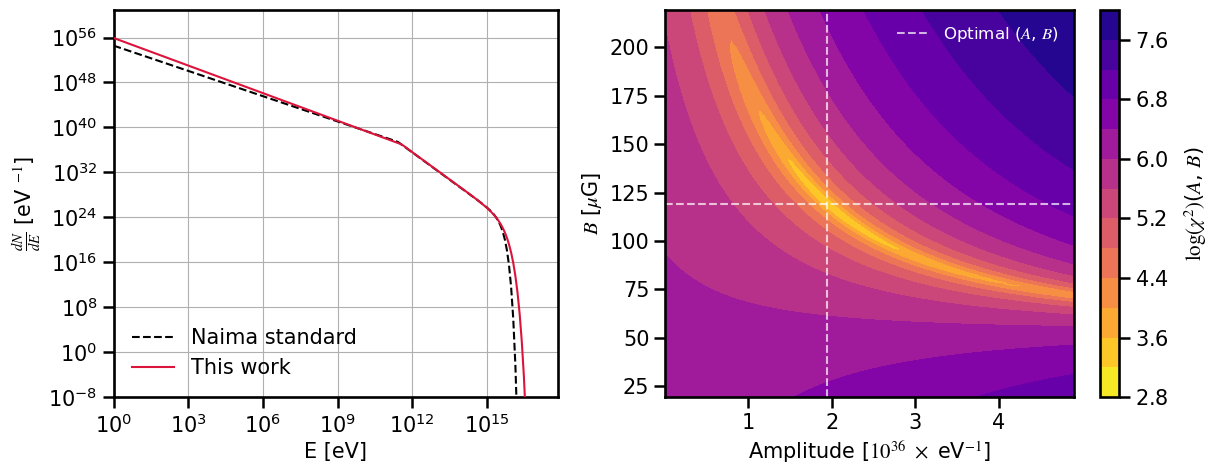

In [41]:
energy = np.logspace(0, 17, 200) * u.eV

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12.5, 5), gridspec_kw={'width_ratios': [1, 1.15]})

ax.plot(energy, ECBPL_electrons(energy, *np.repeat(1, 7)[:-1]).to('1 / eV'),
    lw=1.5, c='k', ls='--', zorder=1, label='Naima standard')

ax.plot(energy, ECBPL_electrons(energy, *fit_params_d3[:-1]).to('1 / eV'),
    lw=1.5, c='crimson', ls='-', zorder=0, label='This work')

ax.loglog()
ax.set_ylabel('$\\frac{dN}{dE}$ [eV ${}^{-1}$]')
ax.set_xlabel('E [eV]')
ax.set_xlim(1, 7e17)
ax.set_ylim(1e-8, 8e60)
ax.legend(frameon=False, loc=3)
ax.grid()
[line.set_zorder(3) for line in ax.lines]

levels=15
cf = ax2.contourf(a_arr* 3.699, b_arr*125, np.log10(LS), cmap='plasma_r', levels=12)# levels=np.logspace(np.log10(np.min(LS)), np.log10(np.max(LS)), levels))

ax2.axvline(fit_params_d3[0]*3.699, lw=1.5, ls='--', color='w', alpha=0.7)
ax2.axhline(fit_params_d3[-1]*125, lw=1.5, ls='--', color='w', alpha=0.7, label='Optimal ($A$, $B$)')

cb = fig.colorbar(cf, ax=ax2, format='%.0e')
cb.set_label('$\log (\chi^2)$($A$, $B$)', labelpad=10)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
formatter.set_scientific(True)

cb.formatter = formatter
cb.update_ticks()

ax2.set_xlabel('Amplitude [$10^{36} \ \\times$ eV${}^{-1}$]')
ax2.set_ylabel('$B$ [$\mu$G]')
ax2.set_xlim(0.01)
cb.ax.yaxis.set_offset_position('left')
offset_text = cb.ax.yaxis.get_offset_text()
offset_text.set_verticalalignment('bottom')
cb.update_ticks()

ax2.legend(loc=1, frameon=False, labelcolor='w', fontsize=12)

fig.tight_layout()

plt.savefig(f'{pltpath}electron-distribution.png', bbox_inches='tight', dpi=dpi)
plt.show()